# eQTL Analysis on 1000 Genomes dataset

### Set instance and token

In [85]:
suppressMessages(library(tidyverse))
library(integrationCurator) # Genestack client library

Sys.setenv(PRED_SPOT_HOST = 'occam.genestack.com',
           PRED_SPOT_TOKEN = '<token>',
           PRED_SPOT_VERSION = 'default-released')

### Get samples

In [86]:
study_filter <- 'genestack:accession=GSF535886'
sample_filter <- paste(sprintf('"Species Or Strain"="%s"', c('British', 'Finnish')),collapse=" OR ")

start <- Sys.time()
samples <- as_tibble(OmicsQueriesApi_search_samples(
    study_filter=study_filter,
    sample_filter=sample_filter
)$content$data[['metadata']])
cat(sprintf('Time to get %s samples: %s seconds\n\n', nrow(samples), round(Sys.time() - start)))

samples <- samples[, c('genestack:accession', 'Species Or Strain')]
head(samples)

Time to get 182 samples: 0 seconds



genestack:accession,Species Or Strain
GSF535900,British
GSF535899,British
GSF535902,British
GSF535901,British
GSF535896,British
GSF535895,British


### Get genotypes

In [87]:
variant <- 'rs17007017'
vx_query <- sprintf('VariationId=%s', variant)

start <- Sys.time()
data <- OmicsQueriesApi_search_variant_data(
    study_filter=study_filter,
    sample_filter=sample_filter,
    vx_query=vx_query
)$content$data
cat(sprintf('Time to get %s genotypes: %s seconds\n\n', nrow(data), round(Sys.time() - start)))

genotypes = cbind(
    'genestack:accession'=data$relationships$sample,
    'genotype'=data$genotype$GT
) %>% as_tibble %>% mutate(genotype = if_else(genotype == '0|1', '1|0', genotype))

head(genotypes)

Time to get 181 genotypes: 10 seconds



genestack:accession,genotype
GSF535888,1|0
GSF535889,0|0
GSF535890,1|0
GSF535891,1|0
GSF535892,0|0
GSF535893,0|0


### Get expression data

In [95]:
gene <- 'ENSG00000109445'
ex_query <- sprintf('Gene=%s MinValue=0.0', gene)

start <- Sys.time()
data <- OmicsQueriesApi_search_expression_data(
    study_filter=study_filter,
    sample_filter=sample_filter,
    ex_query=ex_query
)$content$data
cat(sprintf('Time to get %s expression values: %s seconds\n\n', nrow(data), round(Sys.time() - start)))

expressions <- cbind.data.frame(
    'genestack:accession'=data$relationships$sample,
    'expression'=data$expression
)

head(expressions)

Time to get 174 expression values: 6 seconds



genestack:accession,expression
GSF535888,49.42040
GSF535889,40.24165
GSF535890,34.08621
GSF535891,50.21921
GSF535892,59.59322
GSF535893,54.31705


### eQTL plot

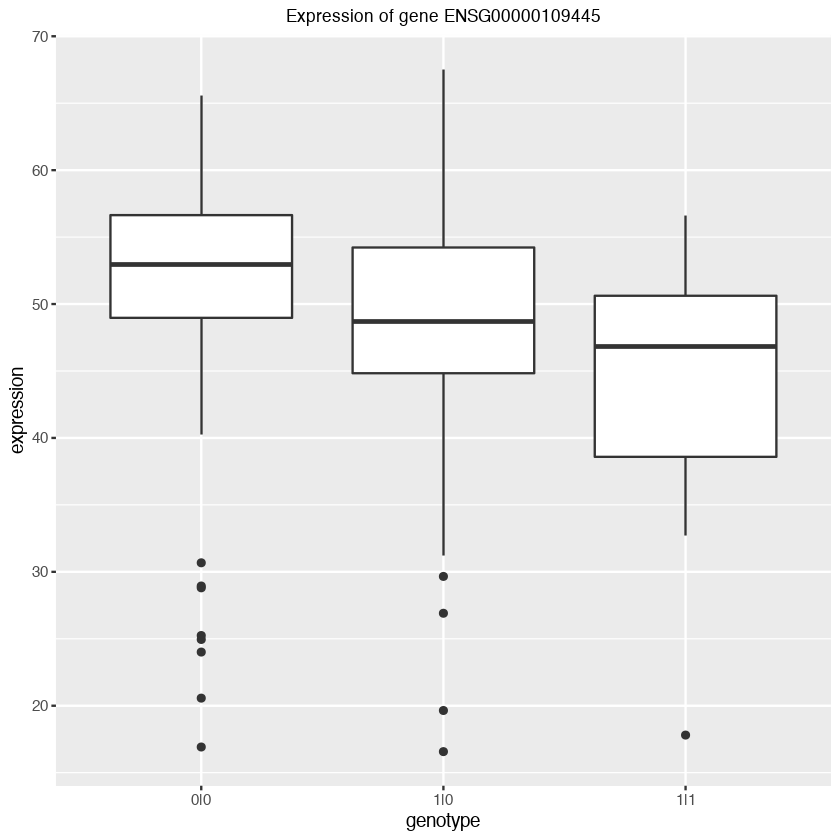

In [96]:
combined_data <- inner_join(
    samples,
    inner_join(genotypes, expressions, by='genestack:accession'),
    by='genestack:accession'
)

ggplot(combined_data,
    mapping=aes(x=genotype, y=expression)) +
    geom_boxplot() + ggtitle(sprintf('Expression of gene %s', gene)) +
    theme(plot.title = element_text(hjust = 0.5, size=10))